# SAM Analysis
Designed to calculate and plot the SAM. Link to [Data analysis](#Data-Analysis).

#### Dask

<br>

#### Choices for data

In [1]:
#Experiment data for analysis
dataVariableId = 'psl'
dataSourceId = "UKESM1-0-LL"
experimentId = "historical"
tableId = "Amon"
memberId = "r1i1p1f2"

externalSAMFileName = "SAMIndex.txt"

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
maskName = "OceanMaskVolcello2"

<br>

#### Imports

In [2]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data loading
<b>Loading the ESM data</b>

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.source_id.eq(dataSourceId) & df.table_id.eq(tableId) & df.experiment_id.eq(experimentId)& df.member_id.eq(memberId)]
#dfFilt = dfFilt[df.member_id.eq(memberId)] #selected member ID

zstore = dfFilt.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
fileRaw = xr.open_zarr(mapper, consolidated=True)

#Formatting dates into np.datetime64 format
startDateIterate = np.datetime64(fileRaw['time'].values[0],'M')
endDateIterate = np.datetime64(fileRaw['time'].values[-1],'M') + np.timedelta64(1,'M')
fileRaw['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
fileRaw['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 

dfESMLat = fileRaw.psl.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded.")

ESM data sucessfully loaded.


<br>
<b>Loading the ocean mask</b>

In [4]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded into oceanMask")

Mask Loaded into oceanMask


<br>
<b>Loading external SAM Index</b>

In [5]:
externalSAMIndex = np.loadtxt("SAMIndex.txt", skiprows=1, max_rows=64)
externalSAMIndexYear = np.transpose(externalSAMIndex)[0]
externalSAMIndexSort = np.empty(shape=(0,2))
for i in range(len(externalSAMIndexYear)):
    for j in range(1,13):
        externalSAMIndexSort = np.append(externalSAMIndexSort, [[np.datetime64(str(int(externalSAMIndexYear[i]))+"-"+f"{j:02d}", "M"), externalSAMIndex[i][j]]], axis=0)
externalSAMIndexSort = np.transpose(externalSAMIndexSort)
print("External SAM index data in "+externalSAMFileName+" loaded into externalSAMIndexSort.")

External SAM index data in SAMIndex.txt loaded into externalSAMIndexSort.


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>externalSAMSearch - returns externalSAMIndexSort between two dates.
<li>SAMCalculateRaw - returns a data array of the difference in pressures between lat -40 and lat -65 (tolerance ±1°) for an input data array, not normalised .
<li>SAMCalculateNorm - returns a data array of the difference in pressures between lat -40 and lat -65 (tolerance ±1°) for an input data array, normalised using second input data array.
</ul>

In [173]:
def externalSAMSearch(startDate, endDate):
    '''Performs np searching across externalSAMIndexSort for start-end date data, returns 2 x n np.array containing [dates][data]'''
    x, startIndex = np.where(externalSAMIndexSort == np.datetime64(startDate, 'M'))
    x, endIndex = np.where(externalSAMIndexSort == np.datetime64(endDate, 'M'))
    dateArray = externalSAMIndexSort[0][startIndex[0] : endIndex[0] + 1]
    dataArray = externalSAMIndexSort[1][startIndex[0] : endIndex[0] + 1]
    externalSAMSearch = np.append([dateArray], [dataArray], axis=0)
    return externalSAMSearch


def SAMCalculateNorm(dataArray):
    '''Calculates the SAM index using P40m, P65m, P40std and P65std. Returns SAM index np array.'''
    timeArray = dataArray["time"].values
    startTimeY = timeArray[0].astype('datetime64[Y]').astype(int) + 1970
    endTimeY = timeArray[-1].astype('datetime64[Y]').astype(int) + 1970
    startTimeM = timeArray[0].astype('datetime64[M]').astype(int) % 12 + 1
    endTimeM = timeArray[-1].astype('datetime64[M]').astype(int) % 12 + 1

    P40 = dataArray.sel(lat=slice(-41, -39))
    P65 = dataArray.sel(lat=slice(-66, -64))

    P40zArray = np.empty(shape=0)
    P65zArray = np.empty(shape=0)
    if startTimeM > 1: #Part start year z transform
        P40YearPartS = P40.sel(time = str(startTimeY))
        P40YearPartS = P40YearPartS.mean(dim=["lat", "lon"])
        P40YearPartS = P40YearPartS.reset_coords(drop=True)
        P40zYearPartS = ((P40YearPartS-P40m[startTimeM-1:])/P40std[startTimeM-1:]).values
        P40zArray = np.append(P40zArray, P40zYearPartS)

        P65YearPartS = P65.sel(time = str(startTimeY))
        P65YearPartS = P65YearPartS.mean(dim=["lat", "lon"])
        P65YearPartS = P65YearPartS.reset_coords(drop=True)
        P65zYearPartS = ((P65YearPartS-P65m[startTimeM-1:])/P65std[startTimeM-1:]).values
        P65zArray = np.append(P65zArray, P65zYearPartS)
        startTimeY += 1  

    P40zYearPartE = np.empty(0)
    P65zYearPartE = np.empty(0)
    if endTimeM < 12: #Part end year z transform
        P40YearPartE = P40.sel(time = str(endTimeY))
        P40YearPartE = P40YearPartE.mean(dim=["lat", "lon"])
        P40YearPartE = P40YearPartE.reset_coords(drop=True)
        P40zYearPartE = ((P40YearPartE-P40m[:endTimeM-12])/P40std[:endTimeM-12]).values

        P65YearPartE = P65.sel(time = str(endTimeY))
        P65YearPartE = P65YearPartE.mean(dim=["lat", "lon"])
        P65YearPartE = P65YearPartE.reset_coords(drop=True)
        P65zYearPartE = ((P65YearPartE-P65m[:endTimeM-12])/P65std[:endTimeM-12]).values
        endTimeY -= 1  

    if startTimeY <= endTimeY: #Full year z transform
        for i in range(startTimeY, endTimeY + 1):
            P40Year = P40.sel(time = str(i))
            P40Year = P40Year.mean(dim=["lat", "lon"])
            P40Year = P40Year.reset_coords(drop=True)
            P40zYear = ((P40Year-P40m)/P40std).values
            P40zArray = np.append(P40zArray, P40zYear)

            P65Year = P65.sel(time = str(i))
            P65Year = P65Year.mean(dim=["lat", "lon"])
            P65Year = P65Year.reset_coords(drop=True)
            P65zYear = ((P65Year-P65m)/P65std).values
            P65zArray = np.append(P65zArray, P65zYear)

    P40zArray = np.append(P40zArray, P40zYearPartE) #Appends End year
    P65zArray = np.append(P65zArray, P65zYearPartE) #Appends End year
    
    SAMArray = P40zArray - P65zArray
    SAMArray = np.round(SAMArray, 2)
    
    exportSAMData = {"time":timeArray, "SAM_Index":SAMArray}
    exportSAMDF = pd.DataFrame(exportSAMData, columns=["time","SAM_Index"])
    return exportSAMDF

print("Calculation functions defined")

Calculation functions defined


<br>
<b>SAM pressure calculations</b>

In [66]:
normalisationData = dfESMLat.sel(time=slice('1971-01','2000-12'))
normalisationDataP40 = normalisationData.sel(lat=slice(-41,-39))
normalisationDataP40M = normalisationDataP40.mean("lat", keep_attrs=True)
normalisationDataP65 = normalisationData.sel(lat=slice(-66,-64))
normalisationDataP65M = normalisationDataP65.mean("lat", keep_attrs=True)

normalisationDataP40MLon = normalisationDataP40M.mean(["lon"], keep_attrs=True)
normalisationDataP65MLon = normalisationDataP65M.mean(["lon"], keep_attrs=True)
normalisationDataP40MLonG = normalisationDataP40MLon.groupby("time.month")
normalisationDataP65MLonG = normalisationDataP65MLon.groupby("time.month")
P40m = normalisationDataP40MLonG.mean(["time"], keep_attrs=True).values
P65m = normalisationDataP65MLonG.mean(["time"], keep_attrs=True).values

normalisationDataP40G = normalisationDataP40.groupby("time.month")
P40std = normalisationDataP40G.std(["lat","lon","time"], keep_attrs=True).values
normalisationDataP65G = normalisationDataP65.groupby("time.month")
P65std = normalisationDataP65G.std(["lat","lon","time"], keep_attrs=True).values

<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li> mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
<li> timePlot -  plots the SAM index in the input data array over time.
<li> timePlotStd - plots the SAM index for a 12 month period (starting January) with error bars.
<li> timePlotYear - plots the SAM index for a 12 month period (starting January) without error bars. Compatible with timePlotStd.
<li> timePlotDecade - plots the SAM index for an input data array over a decade period. Start date is dispalyed as 2001-01.
</ul>

In [190]:
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map.'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))

    
def timePlot(dataArray, label, title, plotNo):
    '''Displays SAM index over time for any given range.'''
    plt.figure(plotNo, figsize = (20,10))
    plt.plot(dataArray["time"], dataArray["SAM_Index"],label = str(label))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(loc='upper right')
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotStd(dataSetMean, dataSetError, title, plotNo):
    '''Displays SAM index with standard deviations over a 12 month period.'''
    plt.figure(plotNo, figsize = (10,10))
    plt.errorbar(months, dataSetMean.values, yerr=dataSetError.values, label = dataSetMean.name, capsize=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotYear(dataArray, title, plotNo):
    '''Displays SAM index for a 12 month period starting in January. Compatible with timePlotStd.'''
    plt.figure(plotNo, figsize = (10,10))
    plt.plot(months, dataArray.values, label = dataArray.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))

def timePlotDecade(dataArray, title, plotNo):
    '''Displays SAM index over a decade.'''
    timeAxis = np.arange(np.datetime64("2001-01"), np.datetime64("2011-01"), np.timedelta64(1, 'M'), dtype='datetime64[M]')
    plt.figure(plotNo, figsize = (20,10))
    plt.plot(timeAxis, dataArray.values, label = dataArray.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel("SAM Index")
    plt.xlabel("Time")
    plt.title(str(title))
    
print("Plotting functions defined")

Plotting functions defined


<br>

#### Plotting the mask

In [ ]:
mapPlot(oceanMask, "Loaded Southern Ocean Mask", 1)

<br>

#### Data Analysis

<br>
<b>SAM index 2005 - 2014</b>

In [176]:
startDate, endDate = "2005-01","2014-12"
extSAM2005_14 = externalSAMSearch(startDate, endDate)
SAM2005_14_data = dfESMLat.sel(time=slice(startDate, endDate))
SAM2005_14 = SAMCalculateNorm(SAM2005_14_data)
print("External and internal SAM calculated for "+startDate+" - "+endDate+".")

External and internal SAM calculated for 2005-01 - 2014-12.


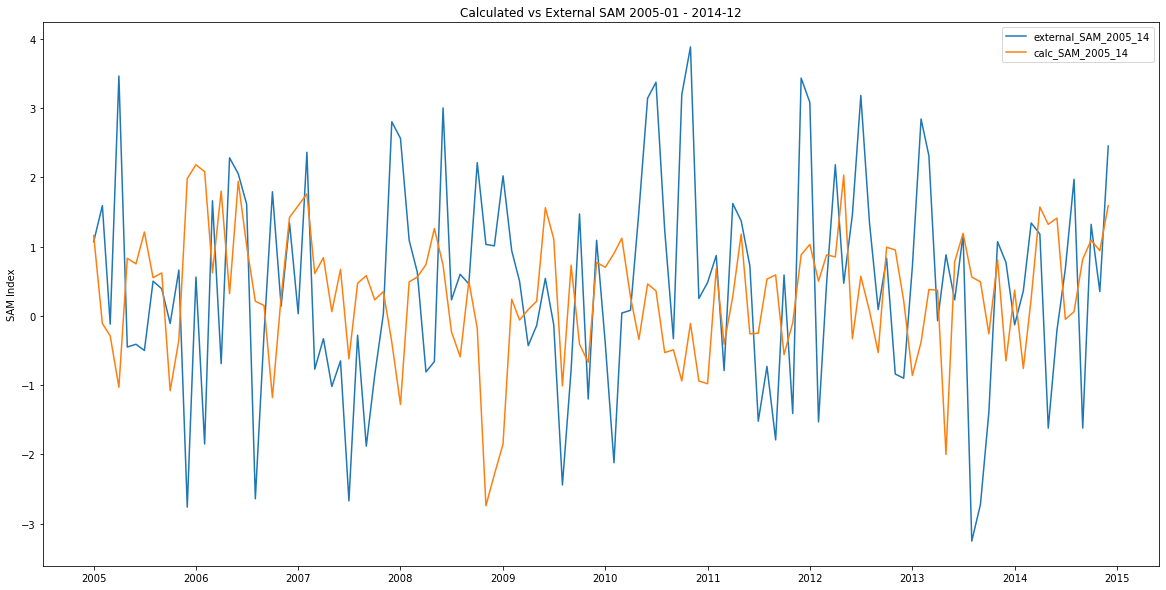

In [191]:
plt.figure(1, figsize=(20,10))
plt.plot(extSAM2005_14[0], extSAM2005_14[1], label="external_SAM_2005_14")
timePlot(SAM2005_14, "calc_SAM_2005_14", "Calculated vs External SAM "+startDate+" - "+endDate, 1)
plt.show()

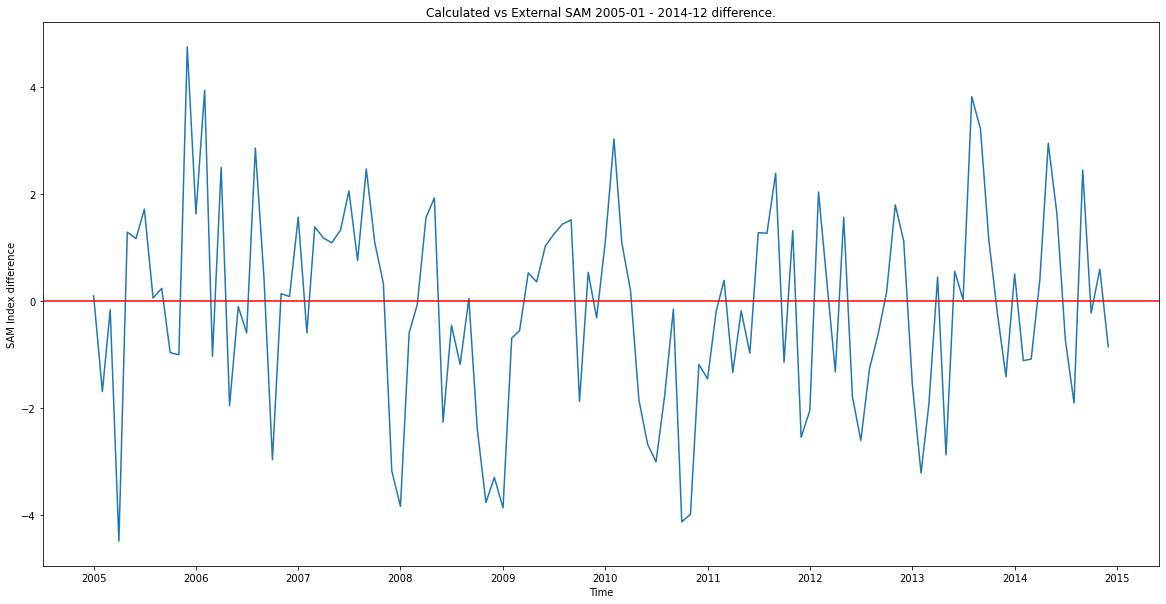

In [187]:
SAMDiff = SAM2005_14["SAM_Index"] - extSAM2005_14[1]
plt.figure(1, figsize=(20,10))
plt.plot(extSAM2005_14[0], SAMDiff, label="external_SAM_2005_14")
plt.axhline(0, color="Red")
plt.title("Calculated vs External SAM "+startDate+" - "+endDate+" difference.")
plt.ylabel("SAM Index difference")
plt.xlabel("Time")
plt.show()

<br>
<b>Decade SAM Index comparison</b><br>
As different decades are being compared the time axis uses 2001 to represent the starting date.

In [194]:
SAM1971_80 = SAMCalculateNorm(dfESMLat.sel(time=slice("1971-01","1980-12")))
SAM1991_00 = SAMCalculateNorm(dfESMLat.sel(time=slice("1991-01","2000-12")))
print("Decade normalised SAMs calculated (1971-80, 1991-2000).")

Decade normalised SAMs calculated (1971-80, 1991-2000).


In [ ]:
timePlotDecade(SAM1971_80N, "Decade average SAM index", 1)
timePlotDecade(SAM1991_00N, "Decade average SAM index", 1)
timePlotDecade(SAM2005_14N, "Decade average SAM index", 1)
plt.show()